In [ ]:
import numpy as np
np.random.seed(42)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

In [ ]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical
import keras
import tensorflow as tf
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=7,
                 use_mfcc=False, n_folds=1, learning_rate=0.001, 
                 max_epochs=50, n_mfcc=100):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [ ]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=1, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=100)

In [ ]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(64, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(64, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(64, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)
    
    x = Convolution2D(64, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    x = Dropout(rate=0.2)(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.2)(x)

    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)
    #opt = optimizers.sgd(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics = METRICS)

    
    return model

In [ ]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

# Speaker

In [15]:
import numpy as np

X_sp_train = np.load('/content/drive/MyDrive/ETRI/X_sp_train_2d.npy')
y_sp_train = np.load('/content/drive/MyDrive/ETRI/y_sp_train_2d.npy')
X_sp_test = np.load('/content/drive/MyDrive/ETRI/X_sp_test_2d.npy')
y_sp_test = np.load('/content/drive/MyDrive/ETRI/y_sp_test_2d.npy')

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')
X_sp_train_sm, y_sp_train_sm = sm.fit_resample(np.array(X_sp_train).reshape(8213, -1), np.array(y_sp_train))
X_sp_train_sm = X_sp_train_sm.reshape(11332, 100, 63)

In [ ]:
model = get_2d_conv_model(config)
history = model.fit(X_sp_train_sm, y_sp_train_sm, validation_data=(X_sp_test, y_sp_test),
                    batch_size=16, epochs=config.max_epochs)

Epoch 1/50
709/709 [==============================] - 24s 20ms/step - loss: 1.3616 - accuracy: 0.5289 - precision: 0.7101 - recall: 0.3416 - auc: 0.8346 - val_loss: 1.5438 - val_accuracy: 0.4547 - val_precision: 0.5262 - val_recall: 0.2678 - val_auc: 0.7883
Epoch 2/50
709/709 [==============================] - 13s 19ms/step - loss: 1.2407 - accuracy: 0.5649 - precision: 0.7528 - recall: 0.3740 - auc: 0.8635 - val_loss: 1.5051 - val_accuracy: 0.4586 - val_precision: 0.5415 - val_recall: 0.3036 - val_auc: 0.8031
Epoch 3/50
709/709 [==============================] - 13s 18ms/step - loss: 1.1951 - accuracy: 0.5797 - precision: 0.7553 - recall: 0.3936 - auc: 0.8741 - val_loss: 1.5198 - val_accuracy: 0.4407 - val_precision: 0.5900 - val_recall: 0.1651 - val_auc: 0.7971
Epoch 4/50
709/709 [==============================] - 14s 20ms/step - loss: 1.1537 - accuracy: 0.5916 - precision: 0.7665 - recall: 0.4132 - auc: 0.8839 - val_loss: 1.7041 - val_accuracy: 0.3893 - val_precision: 0.4288 - val_r

In [ ]:
model.save('/content/drive/MyDrive/ETRI/sp_smote_model.h5')

In [16]:
from keras.models import load_model

wav_sp_model = load_model('/content/drive/MyDrive/ETRI/sp_smote_model.h5')

In [17]:
sp_score = wav_sp_model.evaluate(X_sp_test, y_sp_test , verbose=1)

65/65 [==============================] - 8s 11ms/step - loss: 2.6224 - accuracy: 0.4203 - precision: 0.4387 - recall: 0.3966 - auc: 0.7738


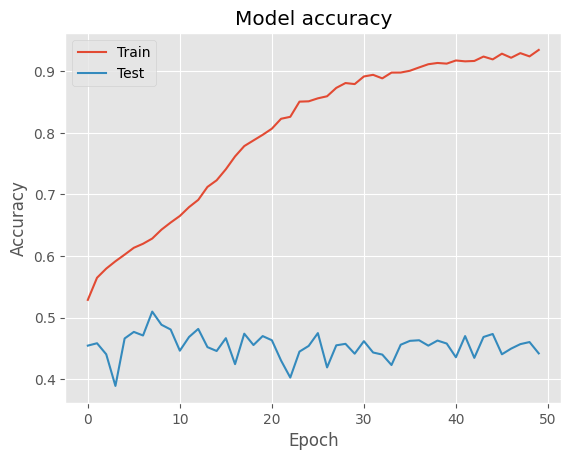

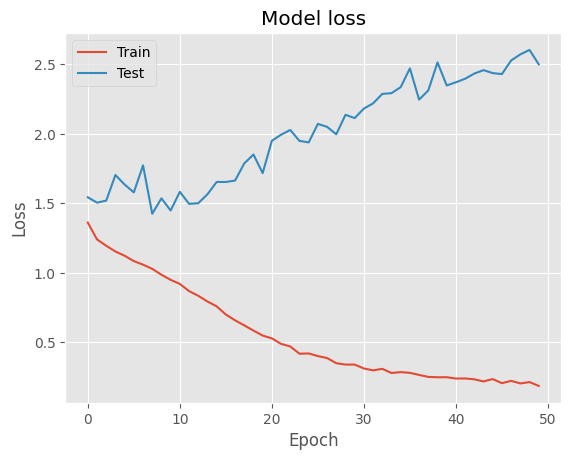

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Listener

In [18]:
import numpy as np

X_li_train = np.load('/content/drive/MyDrive/ETRI/X_li_train_2d.npy')
y_li_train = np.load('/content/drive/MyDrive/ETRI/y_li_train_2d.npy')
X_li_test = np.load('/content/drive/MyDrive/ETRI/X_li_test_2d.npy')
y_li_test = np.load('/content/drive/MyDrive/ETRI/y_li_test_2d.npy')

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')
X_li_train_sm, y_li_train_sm = sm.fit_resample(np.array(X_li_train).reshape(8216, -1), np.array(y_li_train))
X_li_train_sm = X_li_train_sm.reshape(12213, 100, 63)

In [ ]:
model = get_2d_conv_model(config)
history = model.fit(X_li_train_sm, y_li_train_sm, validation_data=(X_li_test, y_li_test),
                    batch_size=16, epochs=config.max_epochs)

Epoch 1/50
764/764 [==============================] - 21s 23ms/step - loss: 1.2766 - accuracy: 0.5631 - precision: 0.6716 - recall: 0.4005 - auc: 0.8340 - val_loss: 1.4300 - val_accuracy: 0.5324 - val_precision: 0.5999 - val_recall: 0.4042 - val_auc: 0.8149
Epoch 2/50
764/764 [==============================] - 14s 18ms/step - loss: 1.1591 - accuracy: 0.6171 - precision: 0.7617 - recall: 0.4457 - auc: 0.8783 - val_loss: 1.4323 - val_accuracy: 0.5329 - val_precision: 0.6116 - val_recall: 0.2759 - val_auc: 0.8137
Epoch 3/50
764/764 [==============================] - 14s 19ms/step - loss: 1.1078 - accuracy: 0.6315 - precision: 0.7736 - recall: 0.4711 - auc: 0.8899 - val_loss: 1.5278 - val_accuracy: 0.4487 - val_precision: 0.6450 - val_recall: 0.1152 - val_auc: 0.7954
Epoch 4/50
764/764 [==============================] - 15s 19ms/step - loss: 1.0662 - accuracy: 0.6444 - precision: 0.7808 - recall: 0.4934 - auc: 0.8985 - val_loss: 1.4137 - val_accuracy: 0.5310 - val_precision: 0.6343 - val_r

In [ ]:
model.save('/content/drive/MyDrive/ETRI/li_smote_model.h5')

In [19]:
wav_li_model = load_model('/content/drive/MyDrive/ETRI/li_smote_model.h5')

In [20]:
li_score = wav_li_model.evaluate(X_li_test, y_li_test , verbose=1)

65/65 [==============================] - 1s 13ms/step - loss: 2.7373 - accuracy: 0.4743 - precision: 0.4937 - recall: 0.4545 - auc: 0.7769


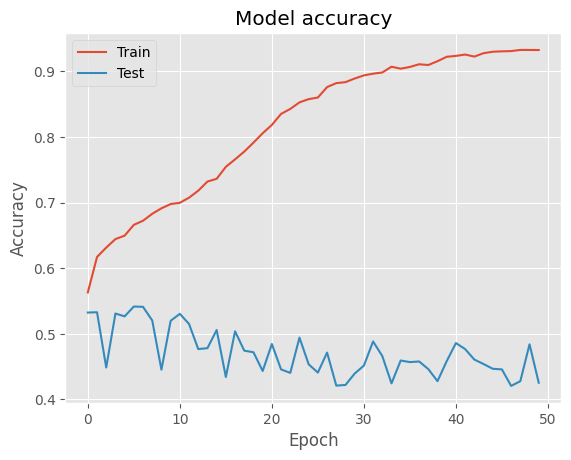

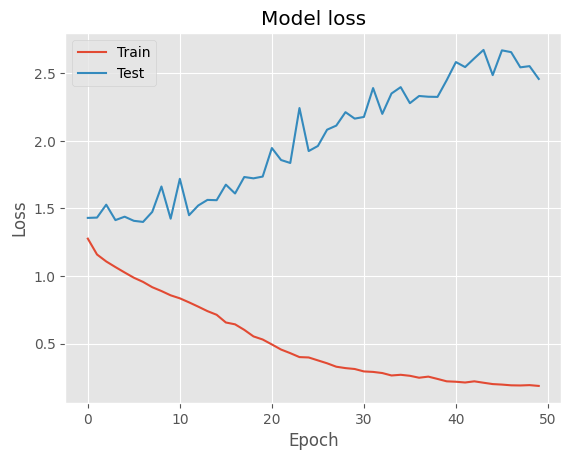

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()